# Introduction
## Overview
This project will use the confusion EEG dataset hosted on Kaggle at https://www.kaggle.com/wanghaohan/eeg-brain-wave-for-confusion.  This dataset consists of EEG data taken from students watching MOOC courses of varying difficulty.  EEG (or electroencephalogram) is a method of monitoring brain activity by using external electrodes placed on the subjects scalp that can measure voltage fluctuations from large numbers of neurons firing.  While these are not precise enough to measure individual neurons, by 'listening' to the brain as a whole they can get a measurement of the frequencies present.  Modern neural models hypothesize that the frequency that neurons fire encode messages, so we may be able to determine information about what the subject is thinking about by looking at those frequencies.  In particular the device used by the researchers is measuring frequencies in the range of Delta waves (waves with a frequency of 1-3 Hz, or oscillations per second), Theta waves (4-7 Hz), Alpha waves (8-11 Hz), Beta waves (12-29 Hz), and Gamma waves (30-100 Hz).  The device also reports a few proprietary measurements supposedly related to paying attention and meditation, along with the raw signal.  Finally we have labels for each of the videos.  The predifined label is whether the researchers expected the subject to be confused or not, and the self defined label is the self reported level of confusion.  Both of these are reported as binary 0s or 1s.
## Problem Statement
The purpose is to identify signals from the EEG that indicate whether or not the student is confused by the subject matter.  In theory confusing subject matter should require additional concentration, or at least a different type of focus from the student, which may be visible in the EEG data.  This could be used in a product providing some sort of computer adaptive educational content with a "consumer" level EEG device (which are becoming more and more available).  For instance if it detects that the student is confused, it can slow down the material, provide some more background material, or just give the student more time to consider what they are learning.  In contrast, if the student shows low levels of confusion, it can be more confident in moving forward.  Computer adaptive education is not a new concept, but typically involves a lot of time consuming testing to see if the student has learned the material.  While this probably would not eliminate the need of testing, it could certainly reduce it.
## Metrics
To test any models I build with this data I willl compute the accuracy score.  The researchers providing the dataset report that an accuracy of 65% ends up being "quite decent", so I will try to improve on that.  However I do not expect to be able to do too much better, as I do not expect this dataset to be sufficiently complete in its description of the subject's brain to get perfect (or even near perfect) accuracy.  Further complicating the matter is that the reporting is rather subjective.  The predefined confusion level is not a particularly accurate measurement because it is based on the researchers preconceptions of what the subjects know.  The self reported confusion level is better, but still is limited in that it depends on the user's internal metric for confusion.  There are also perhaps some honesty issues involved, as a student might believe he or she should not be confused on a certain subject even if he or she is, and thus falsely report a 0.

In [1]:
from pandas import read_csv, concat, DataFrame
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from sklearn.cross_validation import train_test_split, cross_val_score, LabelKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display

In [2]:
raw_data = read_csv("data/EEG data.csv")

Lets first look at this data.

In [3]:
display(raw_data.head())
display(raw_data.describe())

,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0


,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.470377,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499141,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


For these purposes I will group the data by session (one subject and one video) and use the values of the brainwaves in each of the reported ranges.  I will not be using the raw data as it doesn't look like there is enough resolution in the data to see individual brain waves on their own.  I will also not use the propriatary measurements.  They are likely computed as a function of the rest of the data, and therefore not likely useful on their own.  They are also less useful without information on how they are computed.
For the label, I will use the self defined label, since I feel that is more trustworthy.

In [4]:
feature_data = raw_data[['subject ID', 'Video ID', "Delta", "Theta", "Alpha 1", "Alpha 2", "Beta 1", "Beta 2", "Gamma1", "Gamma2", 'Self-defined label']]
sessions = feature_data.groupby(['subject ID', 'Video ID'])
display(sessions.aggregate(np.max)[:10])

Delta    Theta  Alpha 1  Alpha 2  Beta 1  Beta 2  \
subject ID Video ID                                                       
0          0         2723077  1031826   556251   234589  186966  171258   
           1         3224853   826317   304340   221773  139036  131248   
           2         3958185   961497   400302   123180  221211  145414   
           3         2581211  1698512   251577   236024  174228  176850   
           4         2757383  1011493   167859    90579   95771  144309   
           5         3059285  1330245   850147   396815  231739  192808   
           6         2927619  1811549   143813   122927   89965  100927   
           7         1942380   858788   242933    61527   67659  128280   
           8         2505972  1812829   327389   219596   98671  139751   
           9         3529287  1040266   188482   174153  146567  122511   

                     Gamma1  Gamma2  Self-defined label  
subject ID Video ID                                      
0          0         222111   84108                   0  
           1         141042   84001                   1  
           2         164217   66255                   1  
           3         227196  112579                   0  
           4         181573   49188                   0  
           5         340048  138218                   1  
           6         129326   75859                   1  
           7         131320   41331                   0  
           8         184525  106159                   1  
           9         133563   48166                   0

We can try graphing the brainwaves of one of the testing sessions to see how it varies.  Lets look at the brainwave data for subject zero during videos 0 (during which he was not confused) and 1 (during which he was confused).

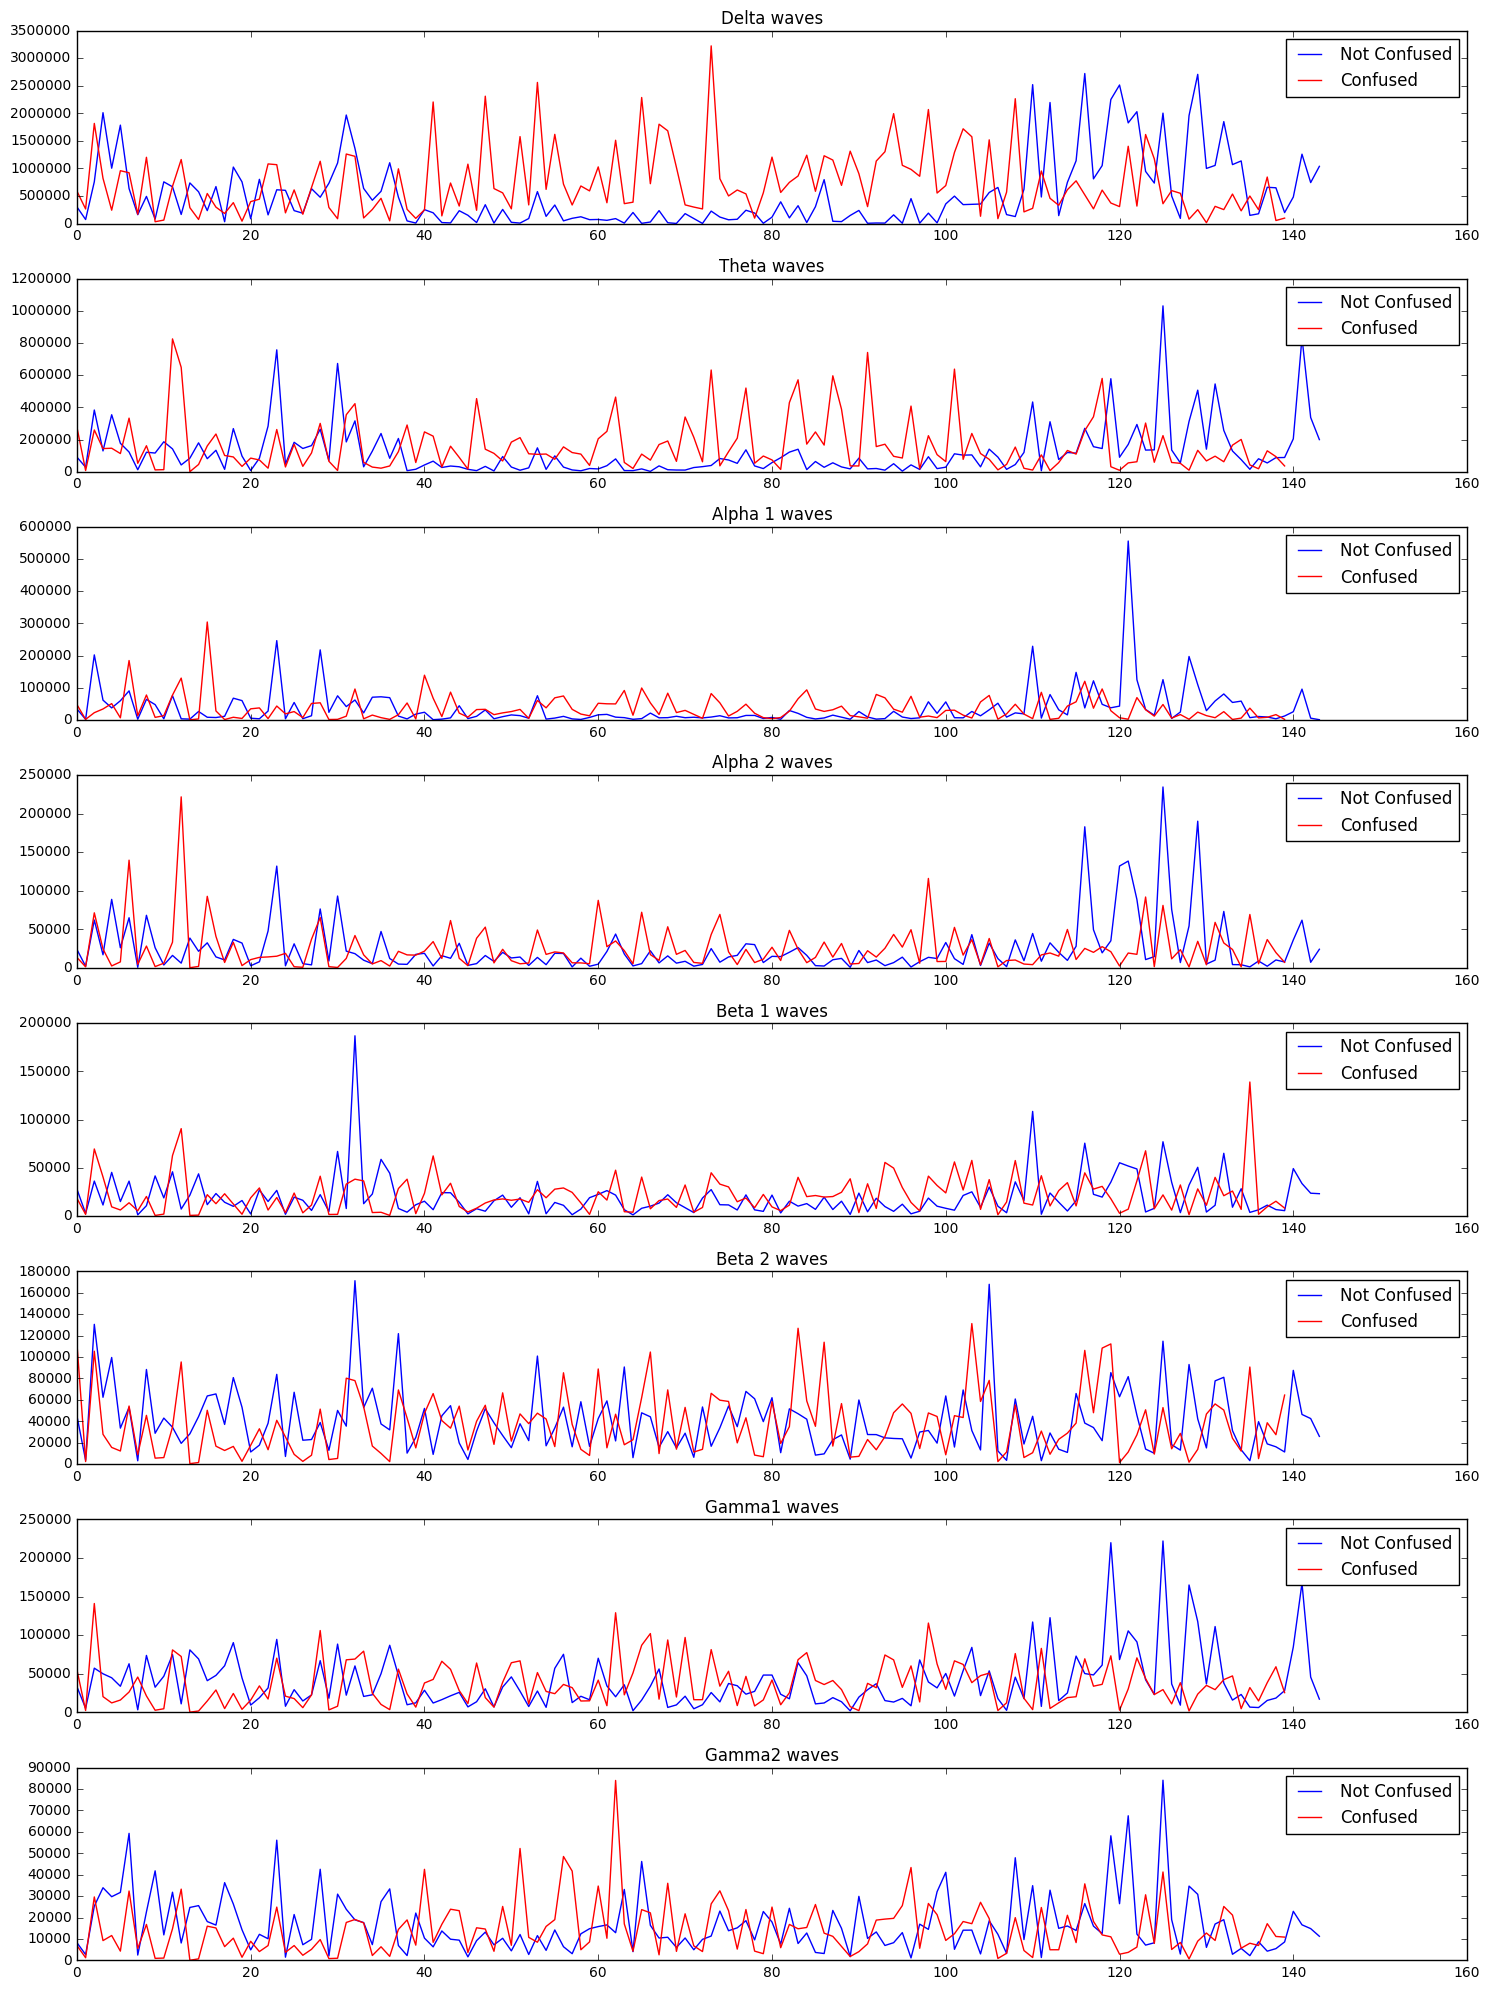

In [5]:
fig, subplots = pyplot.subplots(8, 1, figsize=(15, 20))
not_confused = sessions.get_group((0,0))
confused = sessions.get_group((0,1))
waves = ["Delta", "Theta", "Alpha 1", "Alpha 2", "Beta 1", "Beta 2", "Gamma1", "Gamma2"]
for plot, wave in zip(subplots, waves):
    plot.set_title("%s waves" % wave)
    plot.plot(np.arange(len(not_confused)), not_confused[[wave]], 'b', label="Not Confused")
    plot.plot(np.arange(len(confused)), confused[[wave]], 'r', label="Confused")
    plot.legend()
pyplot.tight_layout()

Here we can see some potential differences.  Several of the wavelengths do seem to be increased while the subject was watching the confusing video, particularly in the lower wavelengths.  The difference seems to be greater in the middle of the video, which could mean either there were times being recorded before and after the video, or there was a "warm up" and "cool down" period for each video during which the subject's brain was no longer considering the video.  However, its also possible the higher activity at the end of the lesson that the students understood is a valid signal.

Lets first try a simple logistic regression against the average values for each of the given brain waves.

In [6]:
aggregated = sessions.aggregate(np.mean)
cols = aggregated.columns[:-1]
averages = aggregated[cols]
averages.columns = ["Average " + col for col in cols]
target = aggregated[aggregated.columns[-1]]
average_data = (averages, target)

def test_model(model, data):
    """
    Run the given model against our data
    """
    features, target = data
    scores = cross_val_score(model, features, target, cv=40, scoring='accuracy')
    return np.mean(scores)


In [7]:
print "Logistic Regression"
print test_model(LogisticRegression(random_state=42) , average_data)

Logistic Regression
0.5875


This gives us a 58.75% accuarcy.  This is not too bad as a first try for this data set, as the researchers report a 65% accuracy as being good.  Nethertheless, lets try a few more models

In [8]:
def run_against_algorithms(data):
    """Run the given data against a set of algorithms"""
    print "Decision Tree"
    print test_model(DecisionTreeClassifier(random_state=42), data)
    print "Gradient Boosting"
    print test_model(GradientBoostingClassifier(random_state=42), data)
    print "AdaBoost"
    print test_model(AdaBoostClassifier(random_state=42), data)
    print "Nearest Neighbor"
    print test_model(KNeighborsClassifier(n_neighbors=1), data)
    print "3 Nearest Neighbors"
    print test_model(KNeighborsClassifier(n_neighbors=3), data)

run_against_algorithms(average_data)

Decision Tree
0.691666666667
Gradient Boosting
0.747916666667
AdaBoost
0.764583333333
Nearest Neighbor
0.645833333333
3 Nearest Neighbors
0.6875


The ensemble methods seem to be doing the best, with the AdaBoost algorithm getting an accuracy of over 75%.

We can look into this algorithm to see what it is keying off of.

In [9]:
def show_feature_importances(features, target, classifier):
    classifier.fit(features, target)
    return display(DataFrame(classifier.feature_importances_, index=features.columns).sort_values(0, ascending=False))
show_feature_importances(averages, target, AdaBoostClassifier(random_state=42))

,0
Average Alpha 2,0.22
Average Delta,0.20
Average Beta 1,0.18
Average Theta,0.12
Average Gamma1,0.10
Average Gamma2,0.10
Average Alpha 1,0.04
Average Beta 2,0.04


It seems to be focusing on higher alpha waves, which is a little surprising as the researchers who collected this data mentioned that theta waves have been shown to be important to confusion.

Because the data is only collected among 10 students and for 10 different videos (they are not independent), it is also important to see how well it generalizes among different students and different videos.  We can use scikit learn's LabelKFold to perform that.

Across different students:
	mean: %f, standard deviation: %f (0.59000000000000008, 0.16999999999999998)
Across different videos:
	mean: %f, standard deviation: %f (0.72000000000000008, 0.097979589711327156)


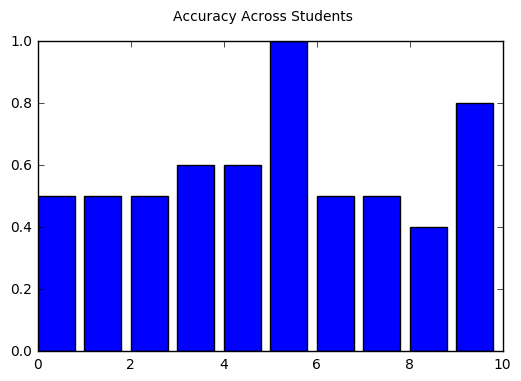

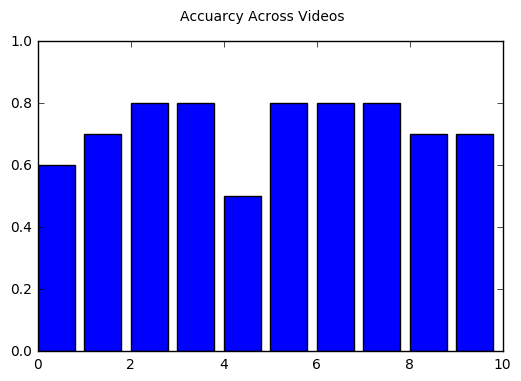

In [10]:
def test_fold(fold, model, x, y):
    """Test the accuracy of a model against a given fold"""
    train_indexes, test_indexes = fold
    x_train = x.as_matrix()[train_indexes]
    x_test = x.as_matrix()[test_indexes]
    y_train = y.as_matrix()[train_indexes]
    y_test = y.as_matrix()[test_indexes]
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    return accuracy_score(y_test, predicted)


def test_across_students(data, classifier):
    """Tests a classifier across different students"""
    student_labels = map(lambda x: x[0], data.index.tolist())
    student_k_fold = LabelKFold(student_labels, 10)
    student_results = [test_fold(fold, classifier, data, target) for fold in student_k_fold]
    student_results.reverse()
    print "Across different students:"
    print "\tmean: %f, standard deviation: %f", (np.mean(student_results), np.std(student_results))
    student_plot = pyplot.figure()
    student_plot.suptitle("Accuracy Across Students")
    pyplot.bar(range(10), student_results)
    pyplot.ylim((0,1.0))

def test_across_videos(data, classifier):
    """Tests a classifier aginst different videos"""
    video_labels = map(lambda x: x[1], data.index.tolist())
    video_k_fold = LabelKFold(video_labels, 10)
    video_results = [test_fold(fold, classifier, data, target) for fold in video_k_fold]
    video_results.reverse()
    print "Across different videos:"
    print "\tmean: %f, standard deviation: %f", (np.mean(video_results), np.std(video_results))
    video_plot = pyplot.figure()
    video_plot.suptitle("Accuarcy Across Videos")
    pyplot.bar(range(10), video_results)
    pyplot.ylim(0,1.0)
    pyplot.show()

test_across_students(averages, AdaBoostClassifier(random_state=42))
test_across_videos(averages, AdaBoostClassifier(random_state=42))

These models tend to generalize fairly well across videos, but poorly across students.  Over half the students were predicted accurately at a rate of 50% or worse.

We can try expanding our features to include other measurements, such as the standard deviations of the levels for each group of brainwaves.  This could help if changes in the brain waves are indictative of confusion, in addition to average values.

In [11]:
std_deviations = sessions.aggregate(np.std)[cols]
std_deviations.columns = [col + " std" for col in cols]
all_features = concat([averages, std_deviations], axis=1)
all_data = (all_features, target)

run_against_algorithms(all_data)

Decision Tree
0.777083333333
Gradient Boosting
0.725
AdaBoost
0.7125
Nearest Neighbor
0.65
3 Nearest Neighbors
0.704166666667


With the additional features, some models (such as decision trees and 3 nearest neighbors) improved, but both the ensemble algorithms did slightly more poorly.  However, the best performing algorithms remain those using decision trees, with the plain decision tree classifier now performing the best.of.

In [12]:
show_feature_importances(all_features, target, DecisionTreeClassifier(random_state=42))

,0
Average Theta,0.270108
Gamma2 std,0.167580
Average Beta 2,0.137392
Average Alpha 1,0.095932
Alpha 2 std,0.090207
Average Gamma2,0.065985
Average Delta,0.046079
Average Alpha 2,0.043351
Gamma1 std,0.036681
Alpha 1 std,0.026677


With this classifier and this data the most important feature is the average theta value.  This is significant as the researchers mention past research suggests theta values correlate with confusion levels.  The deviation of gamma 2 brainwaves and the average beta 2 brainwaves are also relatively significant.

When we test how well this model generalizes we get the following result.

Across different students:
	mean: %f, standard deviation: %f (0.69999999999999996, 0.18973665961010278)
Across different videos:
	mean: %f, standard deviation: %f (0.71999999999999997, 0.14696938456699071)


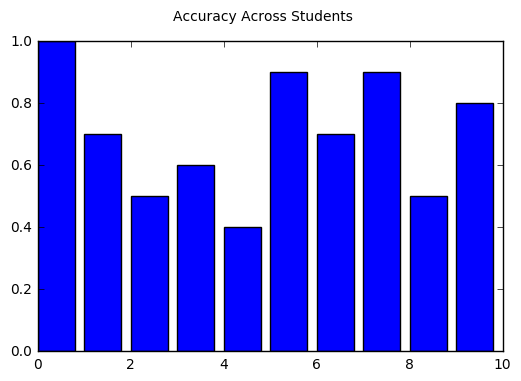

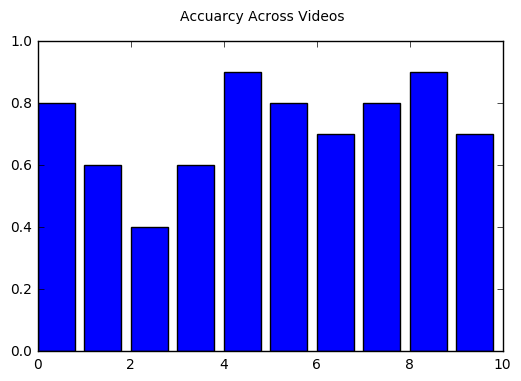

In [13]:
test_across_students(all_features, DecisionTreeClassifier(random_state=42))
test_across_videos(all_features, DecisionTreeClassifier(random_state=42))

These decision tree classifiers seem to be doing about as well across different videos as the AdaBoost classifier that was just looking at mean values, but it is now doing better across different students

When graphing some of the sessions over time, it appeared that the plots looked different at different points in time.  Some of the brainwaves were higher when the subject was confused in the middle of the video, while when the subject was not confused other brainwaves were higher at the end.  We can also try summarizing the data over a few different time periods.  The early data is probably less relevant since the brain has yet to process much or any of the data, so we can drop the first third of the data.  We can then consider the middle third separately from the last third.

In [14]:
def mid_f(f):
    """Run f against of the middle third of the data"""
    def agg(data):
        n = len(data)
        return  f(data[n/3:-n/3])
    return agg

def late_f(f):
    """Run f against the last third of the data"""
    def agg(data):
        n = len(data)
        return f(data[-n/3:])
    return agg

mid_means = sessions.aggregate(mid_f(np.mean))[cols]
mid_means.columns = ["Mid %s Mean" % col for col in cols]
late_means = sessions.aggregate(late_f(np.mean))[cols]
late_means.columns = ["Late %s Mean" % col for col in cols]
time_split = concat([mid_means, late_means], axis=1)
time_split_data = (time_split, target)

run_against_algorithms(time_split_data)

show_feature_importances(time_split, target, DecisionTreeClassifier(random_state=42))

Decision Tree
0.785416666667
Gradient Boosting
0.760416666667
AdaBoost
0.722916666667
Nearest Neighbor
0.629166666667
3 Nearest Neighbors
0.654166666667


,0
Mid Theta Mean,0.437013
Late Delta Mean,0.144192
Mid Beta 1 Mean,0.088924
Late Theta Mean,0.061136
Mid Alpha 1 Mean,0.060024
Late Alpha 1 Mean,0.053355
Mid Beta 2 Mean,0.038803
Mid Delta Mean,0.036521
Mid Gamma1 Mean,0.032321
Mid Alpha 2 Mean,0.031626


We can see the decision tree classifier improved slightly.  Perhaps more interesting is the features that it found important.  The theta waves in the mid part of the video is now much more important in the decision tree's decision making.  And now the late delta waves become important as well, wheras without the time separated data they mattered very little.

Lets now see how a decision tree classifier with this data works across students and videos.

Across different students:
	mean: %f, standard deviation: %f (0.52000000000000013, 0.21354156504062627)
Across different videos:
	mean: %f, standard deviation: %f (0.64999999999999991, 0.14317821063276356)


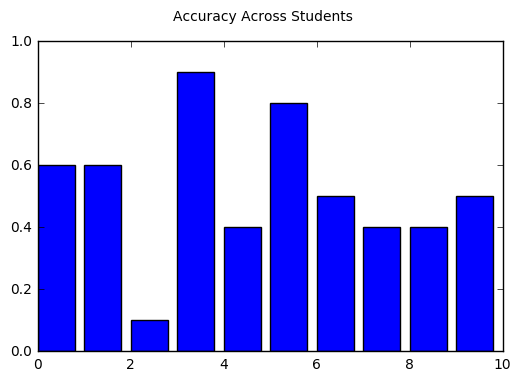

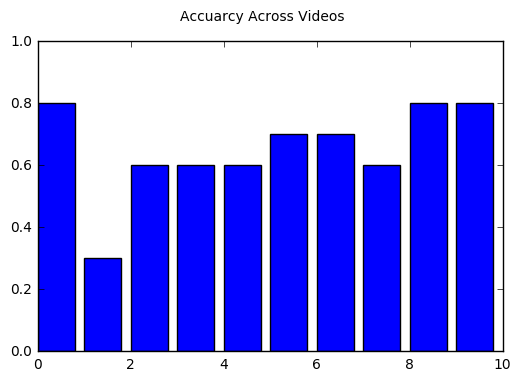

In [15]:
test_across_students(time_split, DecisionTreeClassifier(random_state=42))
test_across_videos(time_split, DecisionTreeClassifier(random_state=42))

Unfortunately these additional features do not help the decision tree generalize across either different students or different videos.  It is particularly bad across different students.  These additional features seem to be causing the models to overfit.  One explanation can be that the late video data is occuring after the student is done with the video, and therefore should not be relevant.  We can try building models with just the middle data.

In [16]:
run_against_algorithms((mid_means, target))

Decision Tree
0.6875
Gradient Boosting
0.783333333333
AdaBoost
0.71875
Nearest Neighbor
0.641666666667
3 Nearest Neighbors
0.625


Here we see that it is the gradient boosting algorithm that is performing the best.  If we investigate it further:

,0
Mid Alpha 2 Mean,0.215272
Mid Theta Mean,0.203108
Mid Gamma2 Mean,0.152900
Mid Delta Mean,0.103543
Mid Beta 1 Mean,0.097387
Mid Gamma1 Mean,0.082917
Mid Beta 2 Mean,0.081064
Mid Alpha 1 Mean,0.063809


Across different students:
	mean: %f, standard deviation: %f (0.66999999999999993, 0.19000000000000003)
Across different videos:
	mean: %f, standard deviation: %f (0.78000000000000003, 0.10770329614269011)


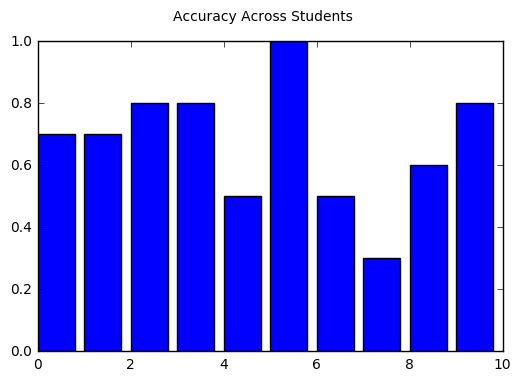

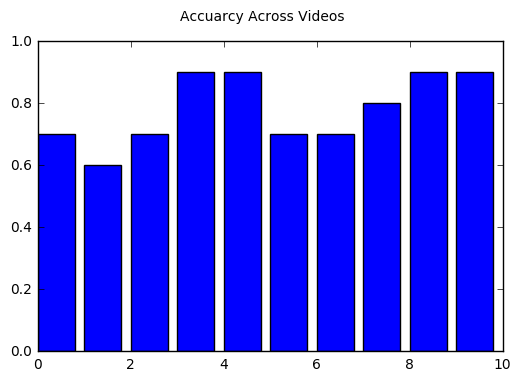

In [17]:
show_feature_importances(mid_means, target, GradientBoostingClassifier(random_state=42))
test_across_students(mid_means, GradientBoostingClassifier(random_state=42))
test_across_videos(mid_means, GradientBoostingClassifier(random_state=42))

Here we get about the same performance we were getting with the decision tree classifier looking at all the data across different students, but noticeably better across different videos.  

Finally, we can combine the process of focusing on the middle part of the dataset with including standard deviations.

In [18]:
mid_stds = sessions.aggregate(mid_f(np.std))[cols]
mid_stds.columns = ["Mid %s Std" % col for col in cols]
middle_means_and_stds = concat([mid_means, mid_stds], axis=1)
run_against_algorithms((middle_means_and_stds, target))

Decision Tree
0.6375
Gradient Boosting
0.7875
AdaBoost
0.779166666667
Nearest Neighbor
0.597916666667
3 Nearest Neighbors
0.608333333333


Here the Gradient Boosting algorithm still seems to be doing the best, though it is only slightly higher than it was with just the means.

In [19]:
show_feature_importances(middle_means_and_stds, target, GradientBoostingClassifier(random_state=42))

,0
Mid Alpha 2 Mean,0.225020
Mid Gamma2 Std,0.141188
Mid Gamma2 Mean,0.118993
Mid Theta Mean,0.103224
Mid Theta Std,0.069433
Mid Beta 1 Std,0.067186
Mid Beta 1 Mean,0.043637
Mid Gamma1 Std,0.040002
Mid Alpha 1 Std,0.034248
Mid Alpha 1 Mean,0.032340


Again Theta waves are not among the top three features, which is surprising.

Across different students:
	mean: %f, standard deviation: %f (0.69999999999999996, 0.16733200530681513)
Across different videos:
	mean: %f, standard deviation: %f (0.77000000000000002, 0.11874342087037919)


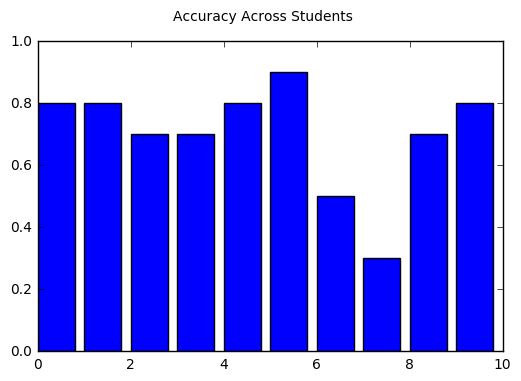

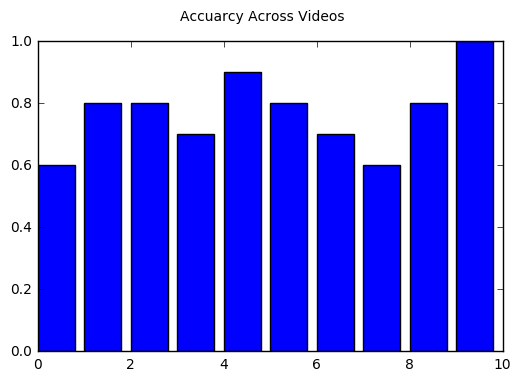

In [20]:
test_across_students(middle_means_and_stds, GradientBoostingClassifier(random_state=42))
test_across_videos(middle_means_and_stds, GradientBoostingClassifier(random_state=42))

Here we get a slight improvement across students, though ever so slightly worse across videos on average.